In [1]:
from __future__ import print_function, division

import os
GPU_id = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt

#import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms, utils



# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
import scanpy as sc
import seaborn as sns 
import pickle

In [3]:
tmp = pd.read_csv('/home/jiwei/miao/bc_visium/benchmark/pbmc_benchmark_spot_exp_df.csv',index_col=0)
tmp.head()

,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,CTC-425K20.1,RP11-599B13.8,RF00561.4,RP11-221H10.2,RP11-220I1.4,RP11-364B6.3,RP11-317B17.3,RP5-958B3.2,RPL31P58,RP11-553E24.1
s1,0,6,1,2,101,0,2,5,1,0,...,0,0,5,1,0,0,0,0,0,0
s2,29,10,5,6,19,0,19,21,6,1,...,0,0,7,1,0,0,0,0,0,0
s3,10,14,2,4,81,0,8,15,1,1,...,0,0,2,1,0,0,0,0,0,0
s4,75,30,4,8,45,1,43,23,4,1,...,0,0,5,1,0,0,0,0,0,0
s5,115,40,5,7,19,1,62,11,6,8,...,0,0,5,1,0,0,0,0,0,0


In [4]:
tmp.shape

(6000, 23381)

In [5]:
pbmc_markers = pd.read_csv('pbmc_markers.csv')
pbmc_markers.head()

,B-cell,CD14+ Monocyte,CD4+ T-cell,CD8+ T-cell,Dendritic cell,FCGR3A+ Monocyte,HEK293T cell,Megakaryocyte,NK cell
0,AFF3,S100A8,INPP4B,CCL5,FCER1A,LST1,ADGRL3,CMTM5,GNLY
1,AC096579.15,S100A9,LEF1,GNLY,HLA-DQB1,TCF7L2,RP5-1024N4.2,PDZK1IP1,NKG7
2,BANK1,AC109326.1,CAMK4,NKG7,CLEC10A,SAT1,RP11-665G4.1,SDPR,GZMB
3,RALGPS2,S100A12,SERINC5,KLRB1,NAPSB,AIF1,SLIT2,AC147651.3,KLRD1
4,IGHM,TYROBP,PRKCA,A2M,HLA-DQA2,MS4A6E,CKB,PPBP,KLRF1


In [21]:
sele_markergenes = []
for i in pbmc_markers.columns:
    sele_markergenes.extend(pbmc_markers[i].tolist())


In [22]:
len(sele_markergenes)


900

In [34]:
len(set(sele_markergenes))


735

In [25]:
class visiumDataset(Dataset):

    def __init__(self, exp_mat, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.spot_gene_exp = exp_mat
        idx = self.spot_gene_exp.index
        x = self.spot_gene_exp.values
        #x = np.log1p(x)
        self.spot_gene_exp = pd.DataFrame(x, columns=self.spot_gene_exp.columns, index=idx)
            
        #self.root_dir = root_dir
        #self.transform = transform

    def __len__(self):
        return len(self.spot_gene_exp)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = torch.Tensor(np.array(self.spot_gene_exp.iloc[idx,0:],dtype='float'))
        
        return sample



In [26]:
%%time

x = np.log1p(tmp.values)
x = (x - np.mean(x, axis=0, keepdims=True))/(1e-5+np.std(x, axis=0, keepdims=True))

CPU times: user 2.42 s, sys: 341 ms, total: 2.76 s
Wall time: 2.76 s


In [27]:
x_df = pd.DataFrame(x,index=tmp.index,columns=tmp.columns)

In [28]:
vd = visiumDataset(exp_mat=x_df[x_df.columns.intersection(set(sele_markergenes))])

In [29]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
                 dataset=vd,#dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True,
                 num_workers=8,
                 #prefetch_factor=64,
)
#test_loader = torch.utils.data.DataLoader(
                #dataset=test_set,
                #batch_size=batch_size,
                #shuffle=False,
                #num_workers=8,
                #prefetch_factor=64,
#)




In [31]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        
        #encoder
        #self.e1 = nn.Linear(21579,1000)
        self.e1 = nn.Linear(721,400)
        self.e2 = nn.Linear(400,100)
        #Latent View
        self.lv = nn.Linear(100,20)
        
        #Decoder
        self.d1 = nn.Linear(20,100)
        self.d2 = nn.Linear(100,400)
        #self.d3 = nn.Linear(500,1000)
        
        self.output_layer = nn.Linear(400,721)
        
    def forward(self,x,output_only=True):
        #x = x.view(-1,8440)
        input = x
        x = F.relu(self.e1(x))
        x = F.relu(self.e2(x))
        #x = F.relu(self.e3(x))
        
        bottle_neck = F.relu(self.lv(x))
        x = F.relu(self.lv(x))#torch.sigmoid(self.lv(x))
        
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        #x = F.relu(self.d3(x))
        
        x = self.output_layer(x) # dim(x) = B, F
        x = (x - input).pow(2).mean(dim=1) # dim(x) = B
        if output_only:
            return x
        else:
            return x,bottle_neck
        

In [30]:
x = next(iter(train_loader))
x.shape

torch.Size([128, 721])

In [32]:
ae_gpu = AutoEncoder().cuda()
print(ae_gpu)

AutoEncoder(
  (e1): Linear(in_features=721, out_features=400, bias=True)
  (e2): Linear(in_features=400, out_features=100, bias=True)
  (lv): Linear(in_features=100, out_features=20, bias=True)
  (d1): Linear(in_features=20, out_features=100, bias=True)
  (d2): Linear(in_features=100, out_features=400, bias=True)
  (output_layer): Linear(in_features=400, out_features=721, bias=True)
)


In [33]:
%%time

# move data to gpu
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(ae_gpu.parameters(),lr=1e-3)

losses = []
EPOCHS = 600
for epoch in range(EPOCHS):
    for batch_idx,data in enumerate(train_loader):
        #data = torch.autograd.Variable(data)
        data = data.cuda()
        optimizer.zero_grad()
        pred,bn = ae_gpu(data,False)
        sparseloss = torch.mean(torch.abs(bn))
        loss = pred.mean() + 0.001*sparseloss#data.view(-1,784)
        #loss = loss_func(pred, data)+0.001*sparseloss#data.view(-1,784)
        # save to logs to draw learning curve
        losses.append(loss.cpu().item())
        loss.backward()
        optimizer.step()
        
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch+1,
        EPOCHS,
        batch_idx * len(data), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().detach().item()))



 Train Epoch: 1/600 [5152/6000 (98%)]	Loss: 0.449131
 Train Epoch: 2/600 [5152/6000 (98%)]	Loss: 0.382160
 Train Epoch: 3/600 [5152/6000 (98%)]	Loss: 0.378618
 Train Epoch: 4/600 [5152/6000 (98%)]	Loss: 0.360406
 Train Epoch: 5/600 [5152/6000 (98%)]	Loss: 0.345883
 Train Epoch: 6/600 [5152/6000 (98%)]	Loss: 0.337637
 Train Epoch: 7/600 [5152/6000 (98%)]	Loss: 0.324942
 Train Epoch: 8/600 [5152/6000 (98%)]	Loss: 0.327535
 Train Epoch: 9/600 [5152/6000 (98%)]	Loss: 0.326330
 Train Epoch: 10/600 [5152/6000 (98%)]	Loss: 0.313229
 Train Epoch: 11/600 [5152/6000 (98%)]	Loss: 0.321077
 Train Epoch: 12/600 [5152/6000 (98%)]	Loss: 0.307488
 Train Epoch: 13/600 [5152/6000 (98%)]	Loss: 0.305887
 Train Epoch: 14/600 [5152/6000 (98%)]	Loss: 0.308466
 Train Epoch: 15/600 [5152/6000 (98%)]	Loss: 0.306319
 Train Epoch: 16/600 [5152/6000 (98%)]	Loss: 0.307818
 Train Epoch: 17/600 [5152/6000 (98%)]	Loss: 0.294980
 Train Epoch: 18/600 [5152/6000 (98%)]	Loss: 0.303535
 Train Epoch: 19/600 [5152/6000 (98%)

In [35]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [36]:
exp_mat=x_df[x_df.columns.intersection(set(sele_markergenes))]
exp_mat.shape

(6000, 721)

In [37]:
nc = NeuronConductance(ae_gpu,ae_gpu.lv)

In [38]:
from tqdm import tqdm

In [39]:
%%time
X = exp_mat.values
res = []
B = 100
for start in tqdm(range(0,6000,B)):
    x = X[start:start+B]
    x = torch.from_numpy(x).float().cuda()
    tmp = []
    for i in range(20):
        att = nc.attribute(x,neuron_selector=i)
        tmp.append(att.detach().cpu().numpy())
    tmp = np.array(tmp) # [20, B, 21579]
    res.append(tmp)
res = np.concatenate(res, axis=1) # [20, 6000, 21579]
res.shape

100%|██████████| 60/60 [03:53<00:00,  3.89s/it]

CPU times: user 3min 51s, sys: 0 ns, total: 3min 51s
Wall time: 3min 53s


(20, 6000, 721)

In [40]:
attr_res = np.mean(res,axis=1)
attr_res.shape

(20, 721)

In [41]:
attr_res_df = pd.DataFrame(attr_res,columns=exp_mat.columns)
attr_res_df.head()

,FGR,CD38,SLC25A5,PRKAR2B,ITGAL,GAS7,CD79B,IL32,RPS20,FYN,...,RP11-231C14.9,RP11-266K4.15,CTD-2515O10.6,RP11-36B6.2,CH17-84K15.2,RP1-93H18.7,ACRBP,PF4,SELP,AC104809.4
0,-0.000013,-0.000014,-0.000024,7.236574e-07,-0.000019,-0.000046,-0.000007,-0.000024,0.000025,-0.000012,...,-0.000005,-0.000004,0.000012,-0.000036,-0.000067,-0.000019,-0.000024,-0.000025,-0.000010,-0.000029
1,0.000014,0.000019,-0.000051,2.651017e-05,-0.000005,0.000009,0.000001,0.000022,0.000035,0.000003,...,-0.000048,-0.000012,-0.000019,0.000028,-0.000008,-0.000016,-0.000019,0.000006,0.000007,-0.000041
2,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000020,-0.000012,-0.000029,2.863021e-06,0.000002,-0.000002,-0.000004,-0.000024,-0.000022,-0.000012,...,-0.000028,-0.000009,-0.000017,0.000002,-0.000033,-0.000026,-0.000008,-0.000007,-0.000031,-0.000026
4,-0.000058,-0.000018,0.000081,5.825666e-05,0.000027,0.000032,-0.000025,0.000041,0.000006,-0.000049,...,0.000063,0.000021,0.000015,0.000046,0.000086,0.000014,0.000006,0.000024,0.000110,0.000040


In [42]:
pbmc_markers = pd.read_csv('pbmc_markers.csv')
pbmc_markers.head()

,B-cell,CD14+ Monocyte,CD4+ T-cell,CD8+ T-cell,Dendritic cell,FCGR3A+ Monocyte,HEK293T cell,Megakaryocyte,NK cell
0,AFF3,S100A8,INPP4B,CCL5,FCER1A,LST1,ADGRL3,CMTM5,GNLY
1,AC096579.15,S100A9,LEF1,GNLY,HLA-DQB1,TCF7L2,RP5-1024N4.2,PDZK1IP1,NKG7
2,BANK1,AC109326.1,CAMK4,NKG7,CLEC10A,SAT1,RP11-665G4.1,SDPR,GZMB
3,RALGPS2,S100A12,SERINC5,KLRB1,NAPSB,AIF1,SLIT2,AC147651.3,KLRD1
4,IGHM,TYROBP,PRKCA,A2M,HLA-DQA2,MS4A6E,CKB,PPBP,KLRF1


In [43]:
from collections import OrderedDict
#n_components = 50
# change to pbmc markers
cell_dict = OrderedDict()
for i in pbmc_markers.columns:
    cell_dict[i] = pbmc_markers[i].values

x = pbmc_markers.columns.values


celltype_counts = OrderedDict()
DF = attr_res_df#.abs()#pd.DataFrame(H) #looking at the H component matrix
for key in cell_dict:
    gene_set = cell_dict[key]
    counts = np.zeros(len(DF)) #array that will hold average cell count for that gene set for all cells 
    for gene in gene_set:
        if gene not in DF.columns:
            continue
        gene_array = DF.loc[:,gene]
        counts = np.add(counts,gene_array)
    counts = np.divide(counts,len(gene_set))
    celltype_counts[key] = counts
#creating dataframe where rows are spots and columns are average expression for each of the cell types
celltypes = np.array(list(celltype_counts.keys()))
spots_celltype = pd.DataFrame()
unfiltered = pd.DataFrame()
for i in celltype_counts:
    spots_celltype[i] = celltype_counts[i]
    unfiltered[i] = celltype_counts[i]
    array = spots_celltype[i] 
    for j in range(len(array)):
        val = array.iloc[j]
        if val < 0.05: #filtering out any values that are super low so as not to be amplified when normalizing
            array.iloc[j] = 0
    ms = np.sum(array) #NORMALIZING BY COLUMN
    spots_celltype[i] = array/ms
spots_celltype = spots_celltype.dropna(axis = 1)

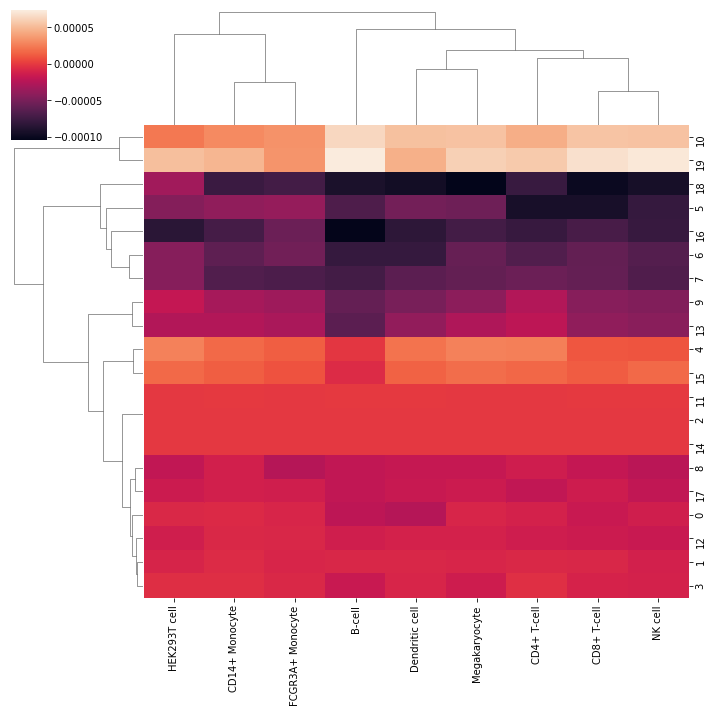

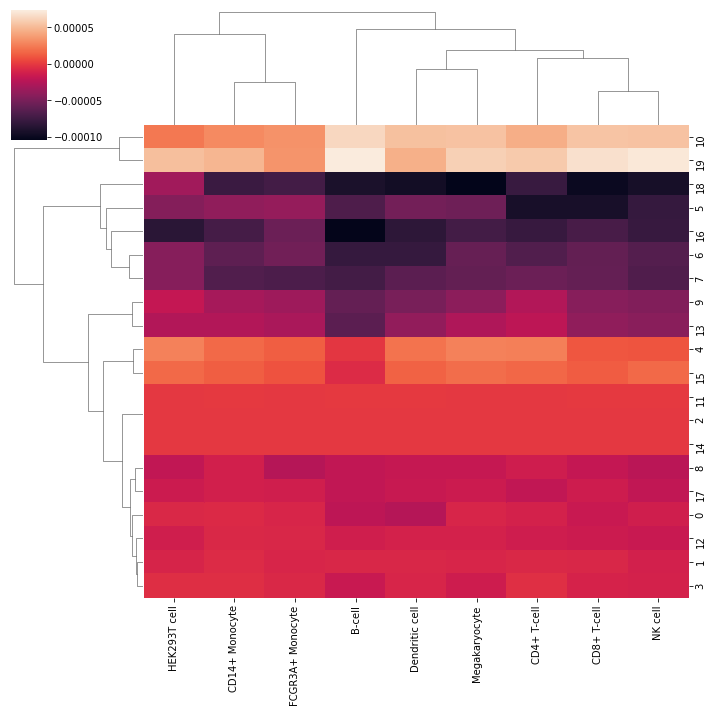

In [44]:
import seaborn as sns
sns.clustermap(unfiltered)#(celltype_counts)
sns.clustermap(celltype_counts)

In [45]:
attr_res_df.to_csv("pbmc_benchmark_ae_bn_sparse_captum_cellmarkers.csv")

In [18]:
cell_df = pd.DataFrame(tmp.index,index=tmp.index)
#tmp = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
cell_df.head()

gene_df = pd.DataFrame(tmp.columns,index=tmp.columns)
#tmp = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
gene_df.head()

adata = sc.AnnData(tmp.values, obs=cell_df, var=gene_df)

#sc.pp.pca(adata_t_tpm)

In [19]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)


In [20]:
adata

AnnData object with n_obs × n_vars = 6000 × 23381
    obs: 0, 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 0, 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

<AxesSubplot:xlabel='n_genes_by_counts'>

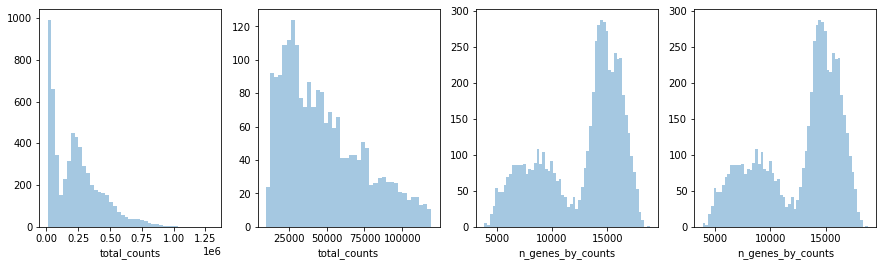

In [21]:
fig,axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 120000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 20000], kde=False, bins=60, ax=axs[3])

In [22]:
#sc.pp.filter_cells(adata, min_counts=5000)
#sc.pp.filter_cells(adata, max_counts=50000)
#adata = adata[adata.obs["pct_counts_mt"] < 30]
#print(f"#cells after MT filter: {adata.n_obs}")
#sc.pp.filter_genes(adata, min_cells=10)

In [23]:

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=6000)

In [24]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

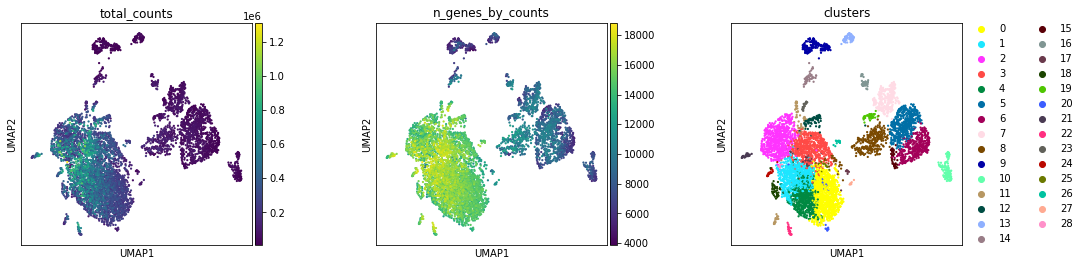

In [25]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

In [26]:
adata

AnnData object with n_obs × n_vars = 6000 × 23381
    obs: 0, 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'clusters'
    var: 0, 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [27]:
class visiumDataset(Dataset):

    def __init__(self, exp_mat, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.spot_gene_exp = exp_mat
        idx = self.spot_gene_exp.index
        x = self.spot_gene_exp.values
        #x = np.log1p(x)
        self.spot_gene_exp = pd.DataFrame(x, columns=self.spot_gene_exp.columns, index=idx)
            
        #self.root_dir = root_dir
        #self.transform = transform

    def __len__(self):
        return len(self.spot_gene_exp)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = torch.Tensor(np.array(self.spot_gene_exp.iloc[idx,0:],dtype='float'))
        
        return sample




In [28]:
%%time

x = np.log1p(tmp.values)
x = (x - np.mean(x, axis=0, keepdims=True))/(1e-5+np.std(x, axis=0, keepdims=True))

CPU times: user 2.32 s, sys: 361 ms, total: 2.68 s
Wall time: 2.68 s


In [29]:
%%time

for col in tmp.columns:
    hasna = tmp[col].isnull().sum()
    if hasna > 0:
        print(col, hasna)

CPU times: user 2.82 s, sys: 8.13 ms, total: 2.83 s
Wall time: 2.82 s


In [30]:
x_df = pd.DataFrame(x,index=tmp.index,columns=tmp.columns)

In [31]:
x_df.head()

,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,CTC-425K20.1,RP11-599B13.8,RF00561.4,RP11-221H10.2,RP11-220I1.4,RP11-364B6.3,RP11-317B17.3,RP5-958B3.2,RPL31P58,RP11-553E24.1
s1,-1.478536,-0.490387,-0.498764,-0.152409,1.680595,-0.360522,-1.016983,-0.309151,-0.484029,-1.131988,...,-0.216277,-0.268533,0.556999,1.244115,0.0,0.0,0.0,0.0,0.0,0.0
s2,0.309682,-0.125791,0.905464,0.956710,0.224277,-0.360522,0.321959,0.899432,0.928105,-0.316588,...,-0.216277,-0.268533,0.927659,1.244115,0.0,0.0,0.0,0.0,0.0,0.0
s3,-0.217816,0.124397,0.019495,0.516265,1.485506,-0.360522,-0.241609,0.603209,-0.484029,-0.316588,...,-0.216277,-0.268533,-0.336075,1.244115,0.0,0.0,0.0,0.0,0.0,0.0
s4,0.798396,0.709977,0.672424,1.285682,0.968784,2.055622,0.878434,0.980369,0.548828,-0.316588,...,-0.216277,-0.268533,0.556999,1.244115,0.0,0.0,0.0,0.0,0.0,0.0
s5,1.020717,0.935505,0.905464,1.131503,0.224277,2.055622,1.131769,0.335609,0.928105,1.452770,...,-0.216277,-0.268533,0.556999,1.244115,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
vd = visiumDataset(exp_mat=x_df[x_df.columns.intersection(adata.var.loc[adata.var['highly_variable'] == True].index.values)])

In [33]:
exp_mat=x_df[x_df.columns.intersection(adata.var.loc[adata.var['highly_variable'] == True].index.values)]
exp_mat.shape
             

(6000, 5999)

In [34]:
len(vd)

6000

In [35]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
                 dataset=vd,#dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True,
                 num_workers=8,
                 #prefetch_factor=64,
)
#test_loader = torch.utils.data.DataLoader(
                #dataset=test_set,
                #batch_size=batch_size,
                #shuffle=False,
                #num_workers=8,
                #prefetch_factor=64,
#)



In [38]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        
        #encoder
        #self.e1 = nn.Linear(21579,1000)
        self.e1 = nn.Linear(5999,500)
        self.e2 = nn.Linear(500,250)
        #Latent View
        self.lv = nn.Linear(250,20)
        
        #Decoder
        self.d1 = nn.Linear(20,250)
        self.d2 = nn.Linear(250,500)
        #self.d3 = nn.Linear(500,1000)
        
        self.output_layer = nn.Linear(500,5999)
        
    def forward(self,x,output_only=True):
        #x = x.view(-1,8440)
        input = x
        x = F.relu(self.e1(x))
        x = F.relu(self.e2(x))
        #x = F.relu(self.e3(x))
        
        bottle_neck = F.relu(self.lv(x))
        x = F.relu(self.lv(x))#torch.sigmoid(self.lv(x))
        
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        #x = F.relu(self.d3(x))
        
        x = self.output_layer(x) # dim(x) = B, F
        x = (x - input).pow(2).mean(dim=1) # dim(x) = B
        if output_only:
            return x
        else:
            return x,bottle_neck
        

In [39]:
x = next(iter(train_loader))
x.shape

torch.Size([128, 5999])

In [40]:
# move model to gpu
ae_gpu = AutoEncoder().cuda()
print(ae_gpu)

AutoEncoder(
  (e1): Linear(in_features=5999, out_features=500, bias=True)
  (e2): Linear(in_features=500, out_features=250, bias=True)
  (lv): Linear(in_features=250, out_features=20, bias=True)
  (d1): Linear(in_features=20, out_features=250, bias=True)
  (d2): Linear(in_features=250, out_features=500, bias=True)
  (output_layer): Linear(in_features=500, out_features=5999, bias=True)
)


In [41]:
%%time

# move data to gpu
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(ae_gpu.parameters(),lr=1e-3)

losses = []
EPOCHS = 600
for epoch in range(EPOCHS):
    for batch_idx,data in enumerate(train_loader):
        #data = torch.autograd.Variable(data)
        data = data.cuda()
        optimizer.zero_grad()
        pred,bn = ae_gpu(data,False)
        sparseloss = torch.mean(torch.abs(bn))
        loss = pred.mean() + 0.001*sparseloss#data.view(-1,784)
        #loss = loss_func(pred, data)+0.001*sparseloss#data.view(-1,784)
        # save to logs to draw learning curve
        losses.append(loss.cpu().item())
        loss.backward()
        optimizer.step()
        
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch+1,
        EPOCHS,
        batch_idx * len(data), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().detach().item()))




 Train Epoch: 1/600 [5152/6000 (98%)]	Loss: 0.690312
 Train Epoch: 2/600 [5152/6000 (98%)]	Loss: 0.671447
 Train Epoch: 3/600 [5152/6000 (98%)]	Loss: 0.671111
 Train Epoch: 4/600 [5152/6000 (98%)]	Loss: 0.657131
 Train Epoch: 5/600 [5152/6000 (98%)]	Loss: 0.625455
 Train Epoch: 6/600 [5152/6000 (98%)]	Loss: 0.596964
 Train Epoch: 7/600 [5152/6000 (98%)]	Loss: 0.603805
 Train Epoch: 8/600 [5152/6000 (98%)]	Loss: 0.615186
 Train Epoch: 9/600 [5152/6000 (98%)]	Loss: 0.592314
 Train Epoch: 10/600 [5152/6000 (98%)]	Loss: 0.619380
 Train Epoch: 11/600 [5152/6000 (98%)]	Loss: 0.624406
 Train Epoch: 12/600 [5152/6000 (98%)]	Loss: 0.608030
 Train Epoch: 13/600 [5152/6000 (98%)]	Loss: 0.609929
 Train Epoch: 14/600 [5152/6000 (98%)]	Loss: 0.614399
 Train Epoch: 15/600 [5152/6000 (98%)]	Loss: 0.557742
 Train Epoch: 16/600 [5152/6000 (98%)]	Loss: 0.574243
 Train Epoch: 17/600 [5152/6000 (98%)]	Loss: 0.573094
 Train Epoch: 18/600 [5152/6000 (98%)]	Loss: 0.547378
 Train Epoch: 19/600 [5152/6000 (98%)

In [42]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [43]:
x_df.shape

(6000, 23381)

In [44]:
#exp_mat=x_df[x_df.columns.intersection(dv[mask].gene.values)]
exp_mat=x_df[x_df.columns.intersection(adata.var.loc[adata.var['highly_variable'] == True].index.values)]
exp_mat.shape

(6000, 5999)

In [45]:
exp_mat.head()

,TSPAN6,SCYL3,C1orf112,FGR,CFH,STPG1,CFTR,RAD52,MYH16,HS3ST1,...,RP11-875O11.4,RP11-569G9.7,RP11-635I10.1,RP11-732A19.1,RP11-34P13.15,RP11-6C10.1,RP11-368I23.1,RPL21P126,TPT1P,RP11-477G18.1
s1,-1.478536,-0.498764,-0.152409,1.680595,-0.360522,-1.131988,-0.345237,0.696550,-0.676,-0.405946,...,1.687821,-0.249171,-0.303269,-0.271941,1.347657,-0.232554,-0.289093,-0.288520,-0.328408,-0.234086
s2,0.309682,0.905464,0.956710,0.224277,-0.360522,-0.316588,-0.345237,0.270020,-0.676,-0.405946,...,-0.411167,-0.249171,-0.303269,-0.271941,-0.027069,-0.232554,-0.289093,-0.288520,-0.328408,-0.234086
s3,-0.217816,0.019495,0.516265,1.485506,-0.360522,-0.316588,-0.345237,-0.132351,-0.676,-0.405946,...,1.687821,3.667398,-0.303269,-0.271941,2.387598,-0.232554,-0.289093,3.332202,-0.328408,-0.234086
s4,0.798396,0.672424,1.285682,0.968784,2.055622,-0.316588,-0.345237,0.429704,-0.676,-0.405946,...,-0.411167,-0.249171,3.064956,-0.271941,0.581257,-0.232554,-0.289093,-0.288520,-0.328408,-0.234086
s5,1.020717,0.905464,1.131503,0.224277,2.055622,1.452770,-0.345237,1.098921,-0.676,-0.405946,...,1.687821,-0.249171,-0.303269,-0.271941,0.581257,-0.232554,-0.289093,-0.288520,-0.328408,-0.234086


In [46]:
nc = NeuronConductance(ae_gpu,ae_gpu.lv)

In [47]:
from tqdm import tqdm

In [48]:
%%time
X = exp_mat.values
res = []
B = 100
for start in tqdm(range(0,6000,B)):
    x = X[start:start+B]
    x = torch.from_numpy(x).float().cuda()
    tmp = []
    for i in range(20):
        att = nc.attribute(x,neuron_selector=i)
        tmp.append(att.detach().cpu().numpy())
    tmp = np.array(tmp) # [20, B, 21579]
    res.append(tmp)
res = np.concatenate(res, axis=1) # [20, 6000, 21579]
res.shape

100%|██████████| 60/60 [03:59<00:00,  4.00s/it]


CPU times: user 3min 59s, sys: 1.85 s, total: 4min 1s
Wall time: 4min


(20, 6000, 5999)

In [49]:
attr_res = np.mean(res,axis=1)
attr_res.shape
attr_res_df = pd.DataFrame(attr_res,columns=exp_mat.columns)
attr_res_df.head()

(20, 5999)

,TSPAN6,SCYL3,C1orf112,FGR,CFH,STPG1,CFTR,RAD52,MYH16,HS3ST1,...,RP11-875O11.4,RP11-569G9.7,RP11-635I10.1,RP11-732A19.1,RP11-34P13.15,RP11-6C10.1,RP11-368I23.1,RPL21P126,TPT1P,RP11-477G18.1
0,-0.000032,-0.000041,-0.000040,-0.000003,-0.000015,-0.000011,-0.000014,-0.000004,-0.000019,-0.000014,...,-5.232558e-06,-0.000018,-0.000006,0.000001,-0.000023,-0.000019,0.000001,-0.000031,-4.454170e-06,-0.000027
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
2,-0.000014,-0.000067,-0.000050,-0.000039,-0.000006,-0.000029,-0.000013,0.000004,0.000002,-0.000011,...,-8.508267e-07,-0.000002,-0.000001,-0.000008,-0.000017,-0.000016,-0.000010,-0.000020,-1.308518e-05,-0.000033
3,-0.000029,-0.000022,-0.000054,-0.000023,-0.000022,-0.000027,-0.000006,-0.000018,-0.000004,0.000001,...,-5.878921e-06,-0.000004,-0.000004,-0.000009,-0.000022,-0.000002,-0.000003,-0.000023,-3.484790e-08,-0.000035
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000


In [51]:
attr_res_df.to_csv("pbmc_benchmark_ae_bn_sparse_captum_6000.csv")

In [49]:
class visiumDataset(Dataset):

    def __init__(self, exp_mat, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.spot_gene_exp = exp_mat
        idx = self.spot_gene_exp.index
        x = self.spot_gene_exp.values
        #x = np.log1p(x)
        self.spot_gene_exp = pd.DataFrame(x, columns=self.spot_gene_exp.columns, index=idx)
            
        #self.root_dir = root_dir
        #self.transform = transform

    def __len__(self):
        return len(self.spot_gene_exp)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = torch.Tensor(np.array(self.spot_gene_exp.iloc[idx,0:],dtype='float'))
        
        return sample



In [50]:
x_df.head()

,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,CTC-425K20.1,RP11-599B13.8,RF00561.4,RP11-221H10.2,RP11-220I1.4,RP11-364B6.3,RP11-317B17.3,RP5-958B3.2,RPL31P58,RP11-553E24.1
s1,-1.478536,-0.490387,-0.498764,-0.152409,1.680595,-0.360522,-1.016983,-0.309151,-0.484029,-1.131988,...,-0.216277,-0.268533,0.556999,1.244115,0.0,0.0,0.0,0.0,0.0,0.0
s2,0.309682,-0.125791,0.905464,0.956710,0.224277,-0.360522,0.321959,0.899432,0.928105,-0.316588,...,-0.216277,-0.268533,0.927659,1.244115,0.0,0.0,0.0,0.0,0.0,0.0
s3,-0.217816,0.124397,0.019495,0.516265,1.485506,-0.360522,-0.241609,0.603209,-0.484029,-0.316588,...,-0.216277,-0.268533,-0.336075,1.244115,0.0,0.0,0.0,0.0,0.0,0.0
s4,0.798396,0.709977,0.672424,1.285682,0.968784,2.055622,0.878434,0.980369,0.548828,-0.316588,...,-0.216277,-0.268533,0.556999,1.244115,0.0,0.0,0.0,0.0,0.0,0.0
s5,1.020717,0.935505,0.905464,1.131503,0.224277,2.055622,1.131769,0.335609,0.928105,1.452770,...,-0.216277,-0.268533,0.556999,1.244115,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
exp_mat=x_df[x_df.columns.intersection(dv[mask].gene.values)]
exp_mat.shape

(6000, 21579)

In [52]:
#vd = visiumDataset(exp_mat=tmp)
#data = df[df.columns.intersection(lst)]
vd = visiumDataset(exp_mat=x_df[x_df.columns.intersection(dv[mask].gene.values)])

In [53]:
len(vd)

6000

In [54]:
exp_mat=tmp[tmp.columns.intersection(dv[mask].gene.values)]
exp_mat.shape

(6000, 21579)

In [55]:
exp_mat.head()

,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,RP11-169L17.3,RP3-477M7.6,RP11-846F4.9,RP11-94D20.1,AC004161.4,RP11-851M3.1,CTC-425K20.1,RP11-599B13.8,RF00561.4,RP11-221H10.2
s1,0,6,1,2,101,0,2,5,1,0,...,1,0,0,0,0,0,0,0,5,1
s2,29,10,5,6,19,0,19,21,6,1,...,0,0,2,0,1,2,0,0,7,1
s3,10,14,2,4,81,0,8,15,1,1,...,1,0,0,0,0,0,0,0,2,1
s4,75,30,4,8,45,1,43,23,4,1,...,4,0,0,0,1,0,0,0,5,1
s5,115,40,5,7,19,1,62,11,6,8,...,2,1,0,0,0,1,0,0,5,1


In [56]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
                 dataset=vd,#dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True,
                 num_workers=8,
                 #prefetch_factor=64,
)
#test_loader = torch.utils.data.DataLoader(
                #dataset=test_set,
                #batch_size=batch_size,
                #shuffle=False,
                #num_workers=8,
                #prefetch_factor=64,
#)


In [57]:
x = next(iter(train_loader))
x.shape

torch.Size([128, 21579])

In [58]:
x.min(),x.max(),x.mean()

(tensor(-5.5124), tensor(15.4813), tensor(-0.0357))

In [59]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        
        #encoder
        self.e1 = nn.Linear(21579,1000)
        self.e2 = nn.Linear(1000,500)
        self.e3 = nn.Linear(500,250)
        #Latent View
        self.lv = nn.Linear(250,20)
        
        #Decoder
        self.d1 = nn.Linear(20,250)
        self.d2 = nn.Linear(250,500)
        self.d3 = nn.Linear(500,1000)
        
        self.output_layer = nn.Linear(1000,21579)
        
    def forward(self,x,output_only=True):
        #x = x.view(-1,8440)
        input = x
        x = F.relu(self.e1(x))
        x = F.relu(self.e2(x))
        x = F.relu(self.e3(x))
        
        bottle_neck = F.relu(self.lv(x))
        x = F.relu(self.lv(x))#torch.sigmoid(self.lv(x))
        
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        x = F.relu(self.d3(x))
        
        x = self.output_layer(x) # dim(x) = B, F
        x = (x - input).pow(2).mean(dim=1) # dim(x) = B
        if output_only:
            return x
        else:
            return x,bottle_neck
        

In [60]:
# move model to gpu
ae_gpu = AutoEncoder().cuda()
print(ae_gpu)

AutoEncoder(
  (e1): Linear(in_features=21579, out_features=1000, bias=True)
  (e2): Linear(in_features=1000, out_features=500, bias=True)
  (e3): Linear(in_features=500, out_features=250, bias=True)
  (lv): Linear(in_features=250, out_features=20, bias=True)
  (d1): Linear(in_features=20, out_features=250, bias=True)
  (d2): Linear(in_features=250, out_features=500, bias=True)
  (d3): Linear(in_features=500, out_features=1000, bias=True)
  (output_layer): Linear(in_features=1000, out_features=21579, bias=True)
)


In [61]:
%%time

# move data to gpu
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(ae_gpu.parameters(),lr=1e-3)

losses = []
EPOCHS = 600
for epoch in range(EPOCHS):
    for batch_idx,data in enumerate(train_loader):
        #data = torch.autograd.Variable(data)
        data = data.cuda()
        optimizer.zero_grad()
        pred,bn = ae_gpu(data,False)
        sparseloss = torch.mean(torch.abs(bn))
        loss = pred.mean() + 0.001*sparseloss#data.view(-1,784)
        #loss = loss_func(pred, data)+0.001*sparseloss#data.view(-1,784)
        # save to logs to draw learning curve
        losses.append(loss.cpu().item())
        loss.backward()
        optimizer.step()
        
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch+1,
        EPOCHS,
        batch_idx * len(data), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().detach().item()))



 Train Epoch: 1/600 [5152/6000 (98%)]	Loss: 0.577443
 Train Epoch: 2/600 [5152/6000 (98%)]	Loss: 0.606157
 Train Epoch: 3/600 [5152/6000 (98%)]	Loss: 0.535084
 Train Epoch: 4/600 [5152/6000 (98%)]	Loss: 0.546524
 Train Epoch: 5/600 [5152/6000 (98%)]	Loss: 0.528636
 Train Epoch: 6/600 [5152/6000 (98%)]	Loss: 0.517842
 Train Epoch: 7/600 [5152/6000 (98%)]	Loss: 0.480832
 Train Epoch: 8/600 [5152/6000 (98%)]	Loss: 0.497840
 Train Epoch: 9/600 [5152/6000 (98%)]	Loss: 0.507242
 Train Epoch: 10/600 [5152/6000 (98%)]	Loss: 0.483077
 Train Epoch: 11/600 [5152/6000 (98%)]	Loss: 0.478532
 Train Epoch: 12/600 [5152/6000 (98%)]	Loss: 0.495941
 Train Epoch: 13/600 [5152/6000 (98%)]	Loss: 0.518459
 Train Epoch: 14/600 [5152/6000 (98%)]	Loss: 0.454921
 Train Epoch: 15/600 [5152/6000 (98%)]	Loss: 0.487359
 Train Epoch: 16/600 [5152/6000 (98%)]	Loss: 0.438918
 Train Epoch: 17/600 [5152/6000 (98%)]	Loss: 0.463648
 Train Epoch: 18/600 [5152/6000 (98%)]	Loss: 0.469765
 Train Epoch: 19/600 [5152/6000 (98%)

In [62]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance


In [63]:
exp_mat=x_df[x_df.columns.intersection(dv[mask].gene.values)]

In [64]:
nc = NeuronConductance(ae_gpu,ae_gpu.lv)

In [65]:
from tqdm import tqdm

In [66]:
%%time
X = exp_mat.values
res = []
B = 100
for start in tqdm(range(0,6000,B)):
    x = X[start:start+B]
    x = torch.from_numpy(x).float().cuda()
    tmp = []
    for i in range(20):
        att = nc.attribute(x,neuron_selector=i)
        tmp.append(att.detach().cpu().numpy())
    tmp = np.array(tmp) # [20, B, 21579]
    res.append(tmp)
res = np.concatenate(res, axis=1) # [20, 6000, 21579]
res.shape

100%|██████████| 60/60 [05:02<00:00,  5.04s/it]


CPU times: user 4min 32s, sys: 48.6 s, total: 5min 21s
Wall time: 5min 23s


(20, 6000, 21579)

In [52]:
attr_res = np.mean(res,axis=1)
attr_res.shape

(20, 5999)

In [68]:
len(dv[mask].gene.values)

21579

In [53]:
dv[mask].gene.values

NameError: name 'dv' is not defined

In [79]:
attr_res_df = pd.DataFrame(attr_res,columns=dv[mask].gene.values)

In [54]:
attr_res_df.head()

,TSPAN6,SCYL3,C1orf112,FGR,CFH,STPG1,CFTR,RAD52,MYH16,HS3ST1,...,RP11-875O11.4,RP11-569G9.7,RP11-635I10.1,RP11-732A19.1,RP11-34P13.15,RP11-6C10.1,RP11-368I23.1,RPL21P126,TPT1P,RP11-477G18.1
0,-0.000032,-0.000041,-0.000040,-0.000003,-0.000015,-0.000011,-0.000014,-0.000004,-0.000019,-0.000014,...,-5.232558e-06,-0.000018,-0.000006,0.000001,-0.000023,-0.000019,0.000001,-0.000031,-4.454170e-06,-0.000027
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
2,-0.000014,-0.000067,-0.000050,-0.000039,-0.000006,-0.000029,-0.000013,0.000004,0.000002,-0.000011,...,-8.508267e-07,-0.000002,-0.000001,-0.000008,-0.000017,-0.000016,-0.000010,-0.000020,-1.308518e-05,-0.000033
3,-0.000029,-0.000022,-0.000054,-0.000023,-0.000022,-0.000027,-0.000006,-0.000018,-0.000004,0.000001,...,-5.878921e-06,-0.000004,-0.000004,-0.000009,-0.000022,-0.000002,-0.000003,-0.000023,-3.484790e-08,-0.000035
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000


In [82]:
max(attr_res_df)

'bP-2189O9.2'

In [83]:
attr_res_df.to_csv("pbmc_benchmark_ae_bn_sparse_captum.csv")

In [40]:
pwd

'/home/jiwei/miao/bc_visium'

,B-cell,CD14+ Monocyte,CD4+ T-cell,CD8+ T-cell,Dendritic cell,FCGR3A+ Monocyte,HEK293T cell,Megakaryocyte,NK cell
0,AFF3,S100A8,INPP4B,CCL5,FCER1A,LST1,ADGRL3,CMTM5,GNLY
1,AC096579.15,S100A9,LEF1,GNLY,HLA-DQB1,TCF7L2,RP5-1024N4.2,PDZK1IP1,NKG7
2,BANK1,AC109326.1,CAMK4,NKG7,CLEC10A,SAT1,RP11-665G4.1,SDPR,GZMB
3,RALGPS2,S100A12,SERINC5,KLRB1,NAPSB,AIF1,SLIT2,AC147651.3,KLRD1
4,IGHM,TYROBP,PRKCA,A2M,HLA-DQA2,MS4A6E,CKB,PPBP,KLRF1


In [56]:
pbmc_markers = pd.read_csv('pbmc_markers.csv')
pbmc_markers.head()
from collections import OrderedDict
#n_components = 50
# change to pbmc markers
cell_dict = OrderedDict()
for i in pbmc_markers.columns:
    cell_dict[i] = pbmc_markers[i].values

x = pbmc_markers.columns.values


celltype_counts = OrderedDict()
DF = attr_res_df#.abs()#pd.DataFrame(H) #looking at the H component matrix
for key in cell_dict:
    gene_set = cell_dict[key]
    counts = np.zeros(len(DF)) #array that will hold average cell count for that gene set for all cells 
    for gene in gene_set:
        if gene not in DF.columns:
            continue
        gene_array = DF.loc[:,gene]
        counts = np.add(counts,gene_array)
    counts = np.divide(counts,len(gene_set))
    celltype_counts[key] = counts
#creating dataframe where rows are spots and columns are average expression for each of the cell types
celltypes = np.array(list(celltype_counts.keys()))
spots_celltype = pd.DataFrame()
unfiltered = pd.DataFrame()
for i in celltype_counts:
    spots_celltype[i] = celltype_counts[i]
    unfiltered[i] = celltype_counts[i]
    array = spots_celltype[i] 
    for j in range(len(array)):
        val = array.iloc[j]
        if val < 0.05: #filtering out any values that are super low so as not to be amplified when normalizing
            array.iloc[j] = 0
    ms = np.sum(array) #NORMALIZING BY COLUMN
    spots_celltype[i] = array/ms
spots_celltype = spots_celltype.dropna(axis = 1)

import seaborn as sns
sns.clustermap(unfiltered)#(celltype_counts)
sns.clustermap(celltype_counts)

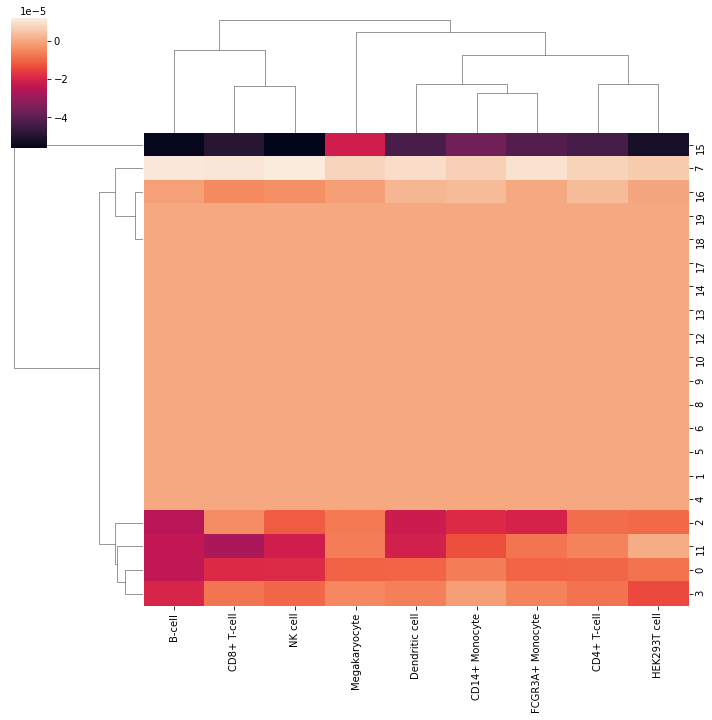

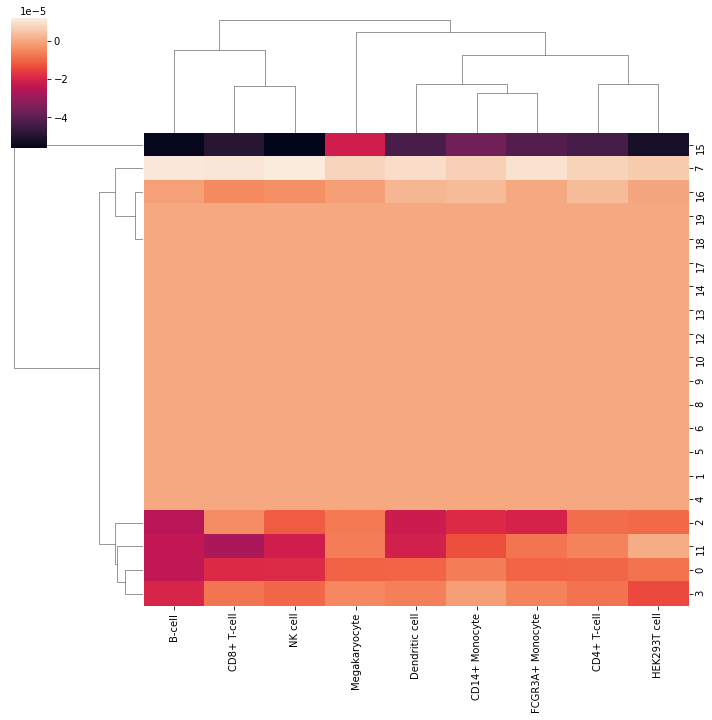

In [ ]:
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
        
visualize_importances(feature_names, np.mean(attribution, axis=0))

In [41]:
in10 = input[:10]
in20 = input[:20]

In [42]:
a10 = nc.attribute(in10,neuron_selector=0)
a20 = nc.attribute(in20,neuron_selector=0)

In [44]:
a10.shape

torch.Size([10, 21579])

In [45]:
(a10==a20[:10]).all()

tensor(True, device='cuda:0')

In [34]:
attribution.shape

torch.Size([500, 21579])

In [100]:
attr = attribution.cpu().detach().numpy()

In [101]:
attr.shape

(100, 21579)

In [108]:
attr_sum = np.sum(attr,axis=0)

In [109]:
len(attr_sum)

21579

In [110]:
max(attr_sum)

0.004718583

In [111]:
min(attr_sum)

-0.0056443885

In [84]:
feature_names = exp_mat.columns

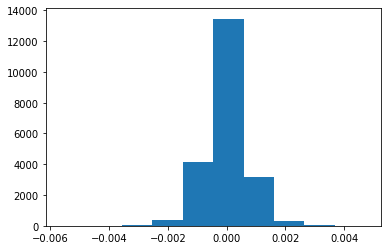

In [113]:
import matplotlib.pyplot as plt
plt.hist(attr_sum)
plt.show()

In [117]:
len(attr_sum>0.002)
len(attr_sum[attr_sum>0.002])

142

In [118]:
feature_names[np.nonzero(attr_sum > 0.002)]

Index(['PHTF2', 'RPS20', 'BIRC3', 'GABARAPL2', 'CDK14', 'CDK17', 'RPL18',
       'TCF3', 'TPD52', 'GRHL2',
       ...
       'CTD-3064H18.1', 'RP11-693J15.4', 'RP11-305K5.1', 'RP11-26J3.4',
       'CH17-66N5.1', 'RP11-473C18.6', 'CH17-84K15.2', 'RP11-430K10.1',
       'PGM5P4-AS1', 'RPL21P126'],
      dtype='object', length=142)

In [119]:
data = np.array([feature_names[np.nonzero(attr_sum > 0.002)],
        attr_sum[attr_sum>0.002]])
  
# Create the pandas DataFrame 
df = pd.DataFrame(data.T, columns = ['gene', 'score']) 
df.head()

,gene,score
0,PHTF2,0.002109
1,RPS20,0.002970
2,BIRC3,0.003490
3,GABARAPL2,0.002092
4,CDK14,0.002790


In [120]:

final_df = df.sort_values(by=['score'], ascending=False)
final_df.head()

,gene,score
79,DENND5B,0.004719
41,ITM2C,0.004331
30,BACH2,0.004160
74,STRBP,0.004140
81,MTSS1,0.004005


In [74]:
attribution

tensor([[-1.8611e-06,  4.4827e-06,  1.0123e-05,  ..., -6.9232e-06,
         -7.7376e-06,  1.6209e-05],
        [-6.4475e-08,  3.0465e-07,  8.6705e-07,  ..., -2.1614e-06,
         -9.8008e-07, -2.5509e-06],
        [-5.4277e-06,  5.3725e-06,  7.5566e-07,  ...,  2.0468e-05,
         -9.1601e-06, -7.2937e-05],
        [ 3.0550e-06,  7.5821e-06,  8.6178e-06,  ..., -1.3240e-05,
          2.8593e-06,  9.0593e-06],
        [-1.4832e-05,  3.1340e-06,  2.7535e-05,  ..., -1.8785e-05,
          6.9975e-06, -5.7620e-05]], device='cuda:0', grad_fn=<MulBackward0>)

In [37]:
ig = IntegratedGradients(ae_gpu)
attr,delta = ig.attribute(input,target=1,return_convergence_delta=True)
attr = attr.detach().numpy()

AttributeError: 'tuple' object has no attribute 'shape'

In [29]:
bn.size()

torch.Size([112, 20])

In [30]:
len(vd)

6000

In [46]:


alldata_loader = torch.utils.data.DataLoader(
                 dataset=vd,#dataset=train_set,
                 batch_size=len(vd),
                 #shuffle=True,
                 num_workers=8,
                 #prefetch_factor=64,
)




In [47]:
for batch_idx,alldata in enumerate(alldata_loader):
    print(batch_idx,alldata.size()) 
    pred_all,bn_all = ae_gpu(alldata.cuda(),False) 

0 torch.Size([6000, 721])


In [48]:
bn_all.size()
#bn_all

torch.Size([6000, 20])

In [49]:
bn_all_np = F.relu(bn_all).cpu().detach().numpy()

In [50]:
bn_all_np[1:4,1:4]

array([[1.1886061 , 0.        , 1.0074152 ],
       [0.32188308, 0.        , 0.7727449 ],
       [0.2989535 , 0.        , 1.1104021 ]], dtype=float32)

In [51]:
bn_df = pd.DataFrame(bn_all_np)

In [52]:
bn_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.026858,0.626888,0.0,0.548971,1.965807,0.583114,0.322982,0.168757,1.741360,1.260514,1.416494,0.0,0.304533,0.551338,0.0,0.974648,2.020634,0.786382,0.675782,0.738486
1,2.216756,1.188606,0.0,1.007415,1.126624,1.186296,2.348714,1.274640,1.586613,0.887760,1.805739,0.0,1.415135,1.697970,0.0,1.399407,1.019761,1.514369,0.961408,1.003738
2,1.602011,0.321883,0.0,0.772745,0.717755,1.038296,1.507544,0.000000,1.993655,1.036661,1.913179,0.0,1.128905,1.107448,0.0,0.851696,1.472613,1.947961,0.440412,1.871652
3,2.178029,0.298954,0.0,1.110402,1.571198,1.286731,0.420722,1.415784,0.958931,2.190361,1.828880,0.0,2.111470,2.128320,0.0,2.656959,1.469475,2.956224,1.766584,2.341617
4,0.383306,0.423145,0.0,0.946101,0.859563,1.212095,0.273884,1.194488,0.769267,1.300116,1.404448,0.0,0.796636,0.857507,0.0,1.655953,0.937562,2.107233,2.266937,1.263750


In [38]:
# try captum

In [53]:

bn_df.columns = ['bn'+str(i+1) for i in bn_df.columns]

Text(684.4999999999999, 0.5, '')

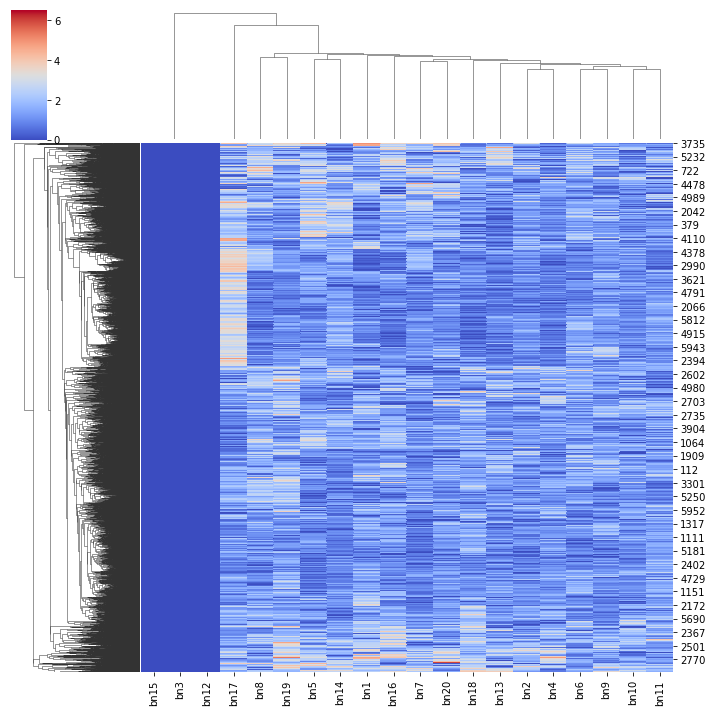

In [54]:
g=sns.clustermap(bn_df,cmap='coolwarm')
ax = g.ax_heatmap
ax.set_ylabel("")

In [55]:
bn_df.to_csv("pbmc_benchmark_ae_bn_sparse_6000_cellmarkers.csv")

In [42]:
# try captum